# **Project 1**, MIE1626 Winter 2022
**Data Science Methods and Quantitative Analysis - Home Credit Default Risk [90 Marks]**

**Deadline: February 11 at 21:00**

**Academic Integrity**

This project is individual: It is to be completed on your own. Do not share your code with others, or post any parts of your work online. You can only submit code that you have written yourself. If you use any online resource for developing parts of your code, acknowledge the source in a comment in your code. Students suspected of plagiarism on a project will be referred to the university for formal discipline according to the Code of Behaviour on Academic Matters.

Please fill out the following:


*   Name: Ali Yassine
*   Student Number: 10086181113
*   UTorID: yassin11 and email ali.yassine@mail.utoronto.ca

I used colab pro+ for higher gpu. I the corrector does not have enough RAM he/she/they can just divide the code in more chuncks. I had problems using only 12 GB 'free' colab. I also processed the data as a whole and then  realized that in the handout the weights were given for some variables were picked. 
But that is not a big deal, i learned more about data pre-processing. 

## **Part 1: Getting started [20 Marks]**

* Load the data

Load the six csv files as pandas dataframes using a string 'path' for the location of files on your system (to be then updated by the marker for evaluation)

In [1]:
pip install varclushi

In [2]:
# Import necessary packages
import pandas as pd
import numpy as np
import math
from varclushi import VarClusHi

from sklearn import feature_selection
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, RandomizedSearchCV, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve, f1_score, precision_score, recall_score, auc, roc_curve, confusion_matrix, classification_report

import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from xgboost import XGBClassifier, plot_importance

import sys

I will load from drive since it is easier 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip '/content/drive/MyDrive/Colab Notebooks/Data.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/Data.zip
replace Data/application_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
### YOUR CODE HERE ###
#e.g. application_train
#application_train = pd.read_csv('application_train.csv')
### YOUR CODE HERE ###
#e.g. application_train
#application_train = pd.read_csv('application_train.csv')
# Note that the main dataset is application_train and the unique identifier for a sample is SK_ID_CURR

application_train = pd.read_csv('Data/application_train.csv')
print(application_train.shape)

# Application data from previous loans that client gotfrom other institutions and that were reported to Credut Bureau
# One row per client's loan in Credit Bureau
bureau=pd.read_csv('Data/bureau.csv')
print(bureau.shape)

# Monthly balance of credits in Credit Bureau
bureau_balance=pd.read_csv('Data/bureau_balance.csv')
print(bureau_balance.shape)

# Monthly balance of client's previous loans in Home credits
# Behovioral data
POS_CASH_balance=pd.read_csv('Data/POS_CASH_balance.csv')
print(POS_CASH_balance.shape)

# Monthly balance of client's previous credit card loans in Home credits
# Behovioral data
credit_card_balance=pd.read_csv('Data/credit_card_balance.csv')
print(credit_card_balance.shape)

# Past payment data for each installments of previous credits in Home Cedit related to loans in our sample
# Behavioral data
installments_payments=pd.read_csv('Data/installments_payments.csv')
print(installments_payments.shape)

(307511, 122)
(1716428, 17)
(27299925, 3)
(10001358, 8)
(3840312, 23)
(13605401, 8)


In [6]:
# make 2 copies of each dataset better in case I messs up in the orginal datasets after no need to re-run and we can use them for extra 
application_train_copy=application_train.copy()
bureau_copy=bureau.copy()
bureau_balance_copy=bureau_balance.copy()
POS_CASH_balance_copy=POS_CASH_balance.copy()
credit_card_balance_copy=credit_card_balance.copy()
installments_payments_copy=installments_payments.copy()

application_train_copy1=application_train.copy()
bureau_copy1=bureau.copy()
bureau_balance_copy1=bureau_balance.copy()
POS_CASH_balance_copy1=POS_CASH_balance.copy()
credit_card_balance_copy1=credit_card_balance.copy()
installments_payments_copy1=installments_payments.copy()

* 1.1 Data transformation and cleaning [15 Marks]

To conduct data cleaning, the first step is create and select relevant features. This includes the
following sub-steps:
1. Remove/disregard features that have a constant value.
2. Remove/disregard features that are irrelevant to credit risk or can’t be explained. This includes
time variables that are only related to the application and other variables that are not related to
the response.
3. Handle missing values.
4. Calculate the proportion of each outcome in dichotomous value to transform categorical variables
to continuous variables (explained below).
5. Create new variables.

See details in the project handout. 

In [7]:
### check the constants no constant variables with one unique value was found
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
from sklearn.feature_selection import VarianceThreshold

### Remove/disregard features that have a constant value.
def remove_constant(df):
  df_copy=df.copy()
  x=df_copy.values

  col=df.columns
  #change to numbers categorical values
  for elem in col : 
    if(df[elem].dtype=='object'):
      df[[elem]] = ord_enc.fit_transform(df[[elem]])
  
  #getting variance 
  var_threshold = VarianceThreshold(threshold=0)   # threshold = 0 for constant
  var_threshold.fit(df)


  #making a numpy array   variances=var_threshold.variances_ 
  variances=var_threshold.variances_
  variances=np.array(variances)
  indexes=[]
  for i in range(0,len(variances)):
    if(variances[i]==0):
      indexes.append(i)
  # delete the constant indices 
  #df_wo_colums=np.delete(x,indexes,axis=1)

  return indexes

def remove_constant_value_features(df):
    return [e for e in df.columns if df[e].nunique() == 1]


a = remove_constant_value_features(application_train_copy)
print(a)

b=remove_constant_value_features(bureau_copy)
print(b)

c=remove_constant_value_features(bureau_balance_copy)
print(c)

d=remove_constant_value_features(POS_CASH_balance_copy)
print(d)

e=remove_constant_value_features(credit_card_balance_copy)
print(e)

f=remove_constant_value_features(installments_payments_copy)
print(f)


a = remove_constant(application_train_copy)
print(a)

b=remove_constant(bureau_copy)
print(b)

c=remove_constant(bureau_balance_copy)
print(c)

d=remove_constant(POS_CASH_balance_copy)
print(d)

e=remove_constant(credit_card_balance_copy)
print(e)

f=remove_constant(installments_payments_copy)
print(f)

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


Let's start by handling application_train because it is our main file . We can't use Pearson correlation to get top 20 features because it would be illogical to pply cross validation in part "  4 Alternative classification model [20 Marks]". If there was no cross validation part in the project I would have picked the top 20 features correlated to the output. Using person correlation to take top 20 features will not be used. I will refer to the handout pdf for the instructions. 

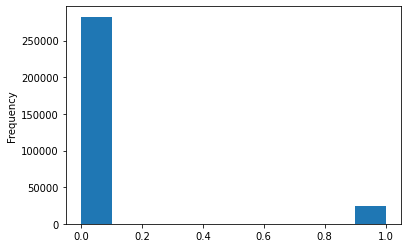

In [8]:
# seems unbalanced umm
application_train['TARGET'].astype(int).plot.hist()

In [9]:
# Function to calculate missing values by column# Funct 
# source: https://leandeep.com/datalab-kaggle/kb002.html
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_values = missing_values_table(application_train)



Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


In [10]:
missing_values

,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


In [11]:
#let's replace inf values with nan : https://ashwni.medium.com/home-credit-default-risk-14d7cbfdeda9
#https://obrunet.github.io/data%20science/Home_credit_default_risk/
# cols_to_drop = list((app_train.isnull().sum() > 210 000).index)
application_train.replace([np.inf,-np.inf],np.nan,inplace=True)

# replacing an outlier in "DAYS_Employed"
# days employed features have many entries that are = 365243 days  (-1000.665753 years) which are outlier so let's just remove them and make them np.nan
application_train["DAYS_EMPLOYED"].replace({365243:np.nan},inplace=True)

# the values of age is negative let's fix it and transform them to years maybe

def convert_age(age_days_negative):
    age_days_positive = -age_days_negative
    age_years = age_days_positive/365
    return age_years

application_train['DAYS_BIRTH'] = application_train['DAYS_BIRTH'].apply(convert_age)
application_train['DAYS_EMPLOYED'] = application_train['DAYS_EMPLOYED'].apply(convert_age)

In [12]:
#outlier in train data where AMT_INCOME_TOTLAL of a operson having higest income had difficulty in paying loan 
application_train=application_train[application_train["AMT_INCOME_TOTAL"]<(0.2*1e8)]

In [13]:
#fill the nan with mean values and for caterorigal values with most common class in column

# fill the nan values https://obrunet.github.io/data%20science/Home_credit_default_risk/
obj_cols = application_train.select_dtypes('object').columns
# filling string caterogical data with most common in cols with https://www.geeksforgeeks.org/pandas-filling-nan-in-categorical-data/
application_train[obj_cols] =  application_train[obj_cols].apply(lambda x: x.fillna(x.value_counts().index[0]))

float_cols = application_train.select_dtypes('float').columns
application_train[float_cols] = application_train[float_cols].fillna(application_train[float_cols].median())
int_cols=application_train.select_dtypes('int64').columns
application_train[int_cols] = application_train[int_cols].fillna(application_train[int_cols].median())

application_train.isnull().sum().sort_values(ascending=False)

SK_ID_CURR                     0
OBS_30_CNT_SOCIAL_CIRCLE       0
WALLSMATERIAL_MODE             0
TOTALAREA_MODE                 0
HOUSETYPE_MODE                 0
                              ..
LIVE_REGION_NOT_WORK_REGION    0
REG_REGION_NOT_WORK_REGION     0
REG_REGION_NOT_LIVE_REGION     0
HOUR_APPR_PROCESS_START        0
AMT_REQ_CREDIT_BUREAU_YEAR     0
Length: 122, dtype: int64

Let's implement the policy described above: for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding.
For label encoding, we use the Scikit-Learn LabelEncoder and for one-hot encoding, the pandas get_dummies(df) function.
https://leandeep.com/datalab-kaggle/kb002.html

In [14]:
from sklearn.preprocessing import LabelEncoder
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in application_train:
    if application_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(application_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(application_train[col])
            # Transform both training and testing data
            application_train[col] = le.transform(application_train[col])
          
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

4 columns were label encoded.


In [15]:
from pandas.core.arrays import categorical
# one-hot encodin for the other categorical variables that are more than 2 
categorical_features=application_train.select_dtypes(include=['object']).columns
application_train=pd.get_dummies(application_train,columns=categorical_features,dummy_na=False)

In [16]:
application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,...,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,1.745205,-3648.0,-2120,9.0,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,45.931507,3.254795,-1186.0,-291,9.0,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,0.535276,0.0959,0.0529,0.9851,0.7960,0.0605,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,52.180822,0.616438,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,0.505998,0.555912,0.729567,0.0876,0.0763,0.9816,0.7552,0.0211,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,52.068493,8.326027,-9833.0,-2437,9.0,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,0.505998,0.650442,0.535276,0.0876,0.0763,0.9816,0.7552,0.0211,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,54.608219,8.323288,-4311.0,-3458,9.0,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,0.505998,0.322738,0.535276,0.0876,0.0763,0.9816,0.7552,0.0211,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,25.553425,0.646575,-8456.0,-1982,9.0,1,1,0,1,0,0,1.0,1,1,15,0,0,0,0,0,0,0.145570,0.681632,0.535276,0.2021,0.0887,0.9876,0.8300,0.0202,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
307507,456252,0,0,0,1,0,72000.0,269550.0,12001.5,225000.0,0.025164,56.917808,4.515068,-4

Now we can pre-process the other datasets before combining them 
I did it in a very long way I believe it can be done easier. I followed all the instructions. The instructions in the PDF told us to fillna by 0 since we will be avereraging values after for each sk_id_curr so it is better to put 0s.

In [17]:
bureau=bureau.fillna(0)
bureau_balance=bureau_balance.fillna(0)
POS_CASH_balance=POS_CASH_balance.fillna(0)
credit_card_balance=credit_card_balance.fillna(0)
installments_payments=installments_payments.fillna(0)

can do while loop did it after

In [18]:
def takeproportioneach(df,feat,groupnb,id):
  x=df.groupby([feat,id])[feat].count()
  y=df.groupby([id])[feat].count()
  w=x[groupnb]
  kik=pd.merge(y, w, on=id,how='left')
  kik[feat +'_y'] = kik[feat+'_y'].fillna(0)
  kik['Proportion'+str(groupnb)] = kik[feat +'_y']/kik[feat+'_x']
  kik=kik.drop([feat +'_y',feat+'_x'],axis=1)
  #df3 = pd.merge(merged_1, kik, on="SK_ID_CURR")
  return kik

prop_0=takeproportioneach(bureau_balance,'STATUS','0','SK_ID_BUREAU')
prop_C=takeproportioneach(bureau_balance,'STATUS','C','SK_ID_BUREAU')
prop_X=takeproportioneach(bureau_balance,'STATUS','X','SK_ID_BUREAU')
prop_1=takeproportioneach(bureau_balance,'STATUS','1','SK_ID_BUREAU')
prop_2=takeproportioneach(bureau_balance,'STATUS','2','SK_ID_BUREAU')
prop_3=takeproportioneach(bureau_balance,'STATUS','3','SK_ID_BUREAU')
prop_5=takeproportioneach(bureau_balance,'STATUS','5','SK_ID_BUREAU')
prop_4=takeproportioneach(bureau_balance,'STATUS','4','SK_ID_BUREAU')

step1=pd.merge(bureau_balance,prop_0,on="SK_ID_BUREAU")
step2=pd.merge(step1,prop_C,on="SK_ID_BUREAU")
step3=pd.merge(step2,prop_X,on="SK_ID_BUREAU")
step4=pd.merge(step3,prop_1,on="SK_ID_BUREAU")
step5=pd.merge(step4,prop_2,on="SK_ID_BUREAU")
step6=pd.merge(step5,prop_3,on="SK_ID_BUREAU")
step7=pd.merge(step6,prop_5,on="SK_ID_BUREAU")
step8=pd.merge(step7,prop_4,on="SK_ID_BUREAU")

bureau_balance=step8.drop(['STATUS'],axis=1)
bureau_balance=bureau_balance.drop(['MONTHS_BALANCE'],axis=1)
bureau_balance

,SK_ID_BUREAU,Proportion0,ProportionC,ProportionX,Proportion1,Proportion2,Proportion3,Proportion5,Proportion4
0,5715448,0.296296,0.333333,0.37037,0.0,0.0,0.0,0.0,0.0
1,5715448,0.296296,0.333333,0.37037,0.0,0.0,0.0,0.0,0.0
2,5715448,0.296296,0.333333,0.37037,0.0,0.0,0.0,0.0,0.0
3,5715448,0.296296,0.333333,0.37037,0.0,0.0,0.0,0.0,0.0
4,5715448,0.296296,0.333333,0.37037,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
27299920,5041336,0.000000,0.000000,1.00000,0.0,0.0,0.0,0.0,0.0
27299921,5041336,0.000000,0.000000,1.00000,0.0,0.0,0.0,0.0,0.0
27299922,5041336,0.000000,0.000000,1.00000,0.0,0.0,0.0,0.0,0.0
27299923,5041336,0.000000,0.000000,1.00000,0.0,0.0,0.0,0.0,0.0


In [19]:
merged_bur_burbalance=pd.merge(bureau_balance, bureau, on="SK_ID_BUREAU")
merged_bur_burbalance=merged_bur_burbalance.drop(['CREDIT_CURRENCY','SK_ID_BUREAU','DAYS_CREDIT','DAYS_CREDIT_ENDDATE','CREDIT_DAY_OVERDUE','DAYS_ENDDATE_FACT','DAYS_CREDIT_UPDATE'],axis=1)

list_all=list(merged_bur_burbalance['CREDIT_TYPE'].unique())
dk_id=list(application_train["SK_ID_CURR"].values)
df_empty = pd.DataFrame({'SK_ID_CURR' : dk_id})
for elem in list_all: 
  prop=takeproportioneach(merged_bur_burbalance,'CREDIT_TYPE',str(elem),'SK_ID_CURR')
  df_empty=pd.merge(df_empty,prop,on='SK_ID_CURR')

merged_bur_burbalance=pd.merge(merged_bur_burbalance, df_empty, on="SK_ID_CURR")
merged_bur_burbalance=merged_bur_burbalance.drop(['CREDIT_TYPE'],axis=1)

list_all=list(merged_bur_burbalance['CREDIT_ACTIVE'].unique())
dk_id=list(application_train["SK_ID_CURR"].values)
df_empty2 = pd.DataFrame({'SK_ID_CURR' : dk_id})
for elem in list_all: 
  prop=takeproportioneach(merged_bur_burbalance,'CREDIT_ACTIVE',str(elem),'SK_ID_CURR')
  df_empty2=pd.merge(df_empty2,prop,on='SK_ID_CURR')

merged_bur_burbalance=pd.merge(merged_bur_burbalance, df_empty2, on="SK_ID_CURR")
merged_bur_burbalance=merged_bur_burbalance.drop(['CREDIT_ACTIVE'],axis=1)

In [20]:
# we still have AMT_CREDIT_MAX_OVERDUE	CNT_CREDIT_PROLONG	AMT_CREDIT_SUM	AMT_CREDIT_SUM_DEBT	AMT_CREDIT_SUM_LIMIT	AMT_CREDIT_SUM_OVERDUE
# start by AMT_CREDIT_SUM_DEBT to see if the client has debt or no Current debt on Credit Bureau credit
# OR let just take mean of each in this way it is easier for us because it will take too much time if I read each variable and process it
# the one highlighted we will take mean for it

# for future use not used here 
def replacewithoneifnot0_then_max(df,feat,variable,id):
  df[feat]=df[feat].fillna(0)
  #If the original value is 0 then keep it as 0, else replace original value with 1.
  #Then, take the maximum of the newly created dummy variable for each SK_ID_CURR.
  df[variable] = (df[feat]!=0).astype(int)
  temp3=df.groupby([id])[variable].max()
  temp3=temp3.reset_index()
  return temp3

merged_bur_burbalance=merged_bur_burbalance.groupby(['SK_ID_CURR']).mean()

In [21]:
merged_bur_burbalance

,Proportion0,ProportionC,ProportionX,Proportion1,Proportion2,Proportion3,Proportion5,Proportion4,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,AMT_ANNUITY,ProportionCredit card,ProportionConsumer credit,ProportionCar loan,ProportionMortgage,ProportionMicroloan,ProportionUnknown type of loan,ProportionAnother type of loan,ProportionLoan for working capital replenishment,ProportionLoan for business development,ProportionCash loan (non-earmarked),ProportionReal estate loan,ProportionMobile operator loan,ProportionLoan for the purchase of equipment,ProportionLoan for purchase of shares (margin lending),ProportionActive,ProportionClosed,ProportionSold,ProportionBad debt
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,0.409091,0.209091,0.136364,0.245455,0.000000,0.0,0.0,0.0,667.932545,0.000000,111388.838727,35749.963636,1163.220545,0.0,0.000000,0.527273,0.472727,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.181818,0.818182,0.0,0.0
100010,0.277778,0.722222,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,495000.000000,174003.750000,0.000000,0.0,0.000000,0.000000,0.500000,0.0,0.000,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0
100019,0.941176,0.000000,0.058824,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,360000.000000,122735.070000,135000.000000,0.0,27000.000000,0.500000,0.500000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0
100032,0.894737,0.000000,0.105263,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,317790.000000,0.000000,0.000000,0.0,17437.500000,0.000000,1.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.750000,0.0,0.0
100033,0.142857,0.000000,0.857143,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,675000.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456244,0.183363,0.709302,0.098390,0.007156,0.001789,0.0,0.0,0.0,1755.567129,0.000000,305030.549866,7651.114495,14.824682,0.0,1534.588551,0.425760,0.574240,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.121646,0.878354,0.0,0.0
456247,0.206250,0.684375,0.109375,0.000000,0.000000,0.0,0.0,0.0,3041.280000,0.031250,367670.334375,164504.250000,0.000000,0.0,3461.920312,0.037500,0.887500,0.0,0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.146875,0.853125,0.0,0.0
456253,0.401709,0.487179,0.111111,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,914615.384615,378608.923077,0.000000,0.0,46396.269231,0.264957,0.735043,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.470085,0.529915,0.0,0.0


In [22]:
# merged with application 
merged_bur_burbalance_application=pd.merge(merged_bur_burbalance, application_train, on="SK_ID_CURR")
merged_bur_burbalance_application

,SK_ID_CURR,Proportion0,ProportionC,ProportionX,Proportion1,Proportion2,Proportion3,Proportion5,Proportion4,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,AMT_ANNUITY_x,ProportionCredit card,ProportionConsumer credit,ProportionCar loan,ProportionMortgage,ProportionMicroloan,ProportionUnknown type of loan,ProportionAnother type of loan,ProportionLoan for working capital replenishment,ProportionLoan for business development,ProportionCash loan (non-earmarked),ProportionReal estate loan,ProportionMobile operator loan,ProportionLoan for the purchase of equipment,ProportionLoan for purchase of shares (margin lending),ProportionActive,ProportionClosed,ProportionSold,ProportionBad debt,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,...,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
0,100002,0.409091,0.209091,0.136364,0.245455,0.000000,0.0,0.0,0.0,667.932545,0.000000,111388.838727,35749.963636,1163.220545,0.0,0.000000,0.527273,0.472727,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.181818,0.818182,0.0,0.0,1,0,0,1,0,202500.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
1,100010,0.277778,0.722222,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,495000.000000,174003.750000,0.000000,0.0,0.000000,0.000000,0.500000,0.0,0.000,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,0,0,1,1,0,360000.0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
2,100019,0.941176,0.000000,0.058824,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,360000.000000,122735.070000,135000.000000,0.0,27000.000000,0.500000,0.500000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0,0,1,1,0,157500.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
3,100032,0.894737,0.000000,0.105263,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,317790.000000,0.000000,0.000000,0.0,17437.500000,0.000000,1.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.750000,0.0,0.0,0,0,0,1,1,112500.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
4,100033,0.142857,0.000000,0.857143,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,675000.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0,0,1,1,0,270000.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

Now it's the turn of installement_payment

In [23]:
#Replace the variables other than amt_installment and amt_payment by average for each sk_id_curr
# read the description not o valuable
temp=installments_payments.groupby(['SK_ID_CURR']).mean()
temp=temp.drop(['SK_ID_PREV','AMT_INSTALMENT','AMT_PAYMENT'],axis=1)

def taketworeplcewithmax(df,feat1,feat2):
  df['PAID_ON_TIME']=(df[feat1]  >= df[feat2] ).astype(int)
  installments_payments=df.drop([feat1,feat2],axis=1)
  temp=df.groupby(['SK_ID_CURR'])['PAID_ON_TIME'].max()
  #temp=temp.drop(['SK_ID_PREV', 'NUM_INSTALMENT_VERSION',	'NUM_INSTALMENT_NUMBER',	'DAYS_INSTALMENT',	'DAYS_ENTRY_PAYMENT'],axis=1)
  temp=temp.reset_index()
  temp=temp.rename(columns={"PAID_ON_TIME": "PAID_ON_TIME_max"})
  #temp=temp.drop([feat1,feat2],axis=1)
  return temp 

x=taketworeplcewithmax(installments_payments,'AMT_PAYMENT','AMT_INSTALMENT')
installments_payments=pd.merge(temp,x, on="SK_ID_CURR")

# for simplicity let just drop NUM_INSTALMENT_VERSION. From this table we just care if the client paid on time. We can add the other features but not much pertinent informations will be added.
# NUM_INSTALMENT_VERSION is Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed
# also let's drop DAYS_INSTALMENT	DAYS_ENTRY_PAYMENT since time only relative to the application
# we will also drop NUM_INSTALMENT_NUMBER
# instal payment will only tell us if the client paid or not. Too many variables will make everything clumsy and as I saw we do not it for LR 
installments_payments=installments_payments.drop(['NUM_INSTALMENT_VERSION',	'NUM_INSTALMENT_NUMBER'	,'DAYS_INSTALMENT',	'DAYS_ENTRY_PAYMENT'],axis=1)
installments_payments

,SK_ID_CURR,PAID_ON_TIME_max
0,100001,1
1,100002,1
2,100003,1
3,100004,1
4,100005,1
...,...,...
339582,456251,1
339583,456252,1
339584,456253,1
339585,456254,1


Now for credit card balance 

In [24]:
def returnaverageperSK_ID(df,list):
    return df.groupby(['SK_ID_CURR']) [list].mean().reset_index()

#added 'AMT_INST_MIN_REGULARITY','AMT_CREDIT_LIMIT_ACTUAL' AMT_RECEIVABLE_PRINCIPAL because also float variable to be averaged
# I have added more variables than the one mentionned in document 
df1=returnaverageperSK_ID(credit_card_balance,['CNT_DRAWINGS_ATM_CURRENT','AMT_DRAWINGS_ATM_CURRENT','AMT_DRAWINGS_CURRENT','AMT_DRAWINGS_OTHER_CURRENT','AMT_DRAWINGS_POS_CURRENT','AMT_RECIVABLE','AMT_TOTAL_RECEIVABLE','AMT_INST_MIN_REGULARITY','AMT_CREDIT_LIMIT_ACTUAL','AMT_RECEIVABLE_PRINCIPAL','CNT_DRAWINGS_CURRENT',	'CNT_DRAWINGS_OTHER_CURRENT'	,'CNT_DRAWINGS_POS_CURRENT'	,'CNT_INSTALMENT_MATURE_CUM'])

temp_credit_balance=credit_card_balance.drop(['CNT_DRAWINGS_ATM_CURRENT','AMT_DRAWINGS_ATM_CURRENT','AMT_DRAWINGS_CURRENT','AMT_DRAWINGS_OTHER_CURRENT','AMT_DRAWINGS_POS_CURRENT','AMT_RECIVABLE','AMT_TOTAL_RECEIVABLE','AMT_INST_MIN_REGULARITY','AMT_CREDIT_LIMIT_ACTUAL','AMT_RECEIVABLE_PRINCIPAL','CNT_DRAWINGS_CURRENT',	'CNT_DRAWINGS_OTHER_CURRENT'	,'CNT_DRAWINGS_POS_CURRENT'	,'CNT_INSTALMENT_MATURE_CUM','SK_ID_PREV'],axis=1)

# for AMT_balance	AMT_PAYMENT_TOTAL_CURRENT do the same thing as before to see if the client paid his balance
def taketworeplcewithmax(df,feat1,feat2):
  df['PAID_ON_TIME']=(df[feat1]  >= df[feat2] ).astype(int)
  df=df.drop([feat1,feat2],axis=1)
  temp=df.groupby(['SK_ID_CURR'])['PAID_ON_TIME'].max()
  #temp=temp.drop(['SK_ID_PREV', 'NUM_INSTALMENT_VERSION',	'NUM_INSTALMENT_NUMBER',	'DAYS_INSTALMENT',	'DAYS_ENTRY_PAYMENT'],axis=1)
  temp=temp.reset_index()
  temp=temp.rename(columns={"PAID_ON_TIME": "PAID_ON_TIME_credit_balance_max"})
  #temp=temp.drop([feat1,feat2],axis=1)
  return temp 

x=taketworeplcewithmax(temp_credit_balance,'AMT_PAYMENT_TOTAL_CURRENT','AMT_BALANCE')
credit_card_balance_1=pd.merge(df1,x,on="SK_ID_CURR")
temp_credit_balance=temp_credit_balance.drop(['AMT_PAYMENT_TOTAL_CURRENT','AMT_BALANCE'],axis=1)

# for name contract status do same as before
list_all=list(temp_credit_balance['NAME_CONTRACT_STATUS'].unique())
dk_id=list(application_train["SK_ID_CURR"].values)
df_empty2 = pd.DataFrame({'SK_ID_CURR' : dk_id})
for elem in list_all: 
  prop=takeproportioneach(temp_credit_balance,'NAME_CONTRACT_STATUS',str(elem),'SK_ID_CURR')
  df_empty2=pd.merge(df_empty2,prop,on='SK_ID_CURR')

credit_card_balance_2=pd.merge(credit_card_balance_1,df_empty2,on='SK_ID_CURR')
temp_credit_balance=temp_credit_balance.drop(['AMT_PAYMENT_CURRENT','NAME_CONTRACT_STATUS'],axis=1)


In [25]:
temp_credit_balance

,SK_ID_CURR,MONTHS_BALANCE,SK_DPD,SK_DPD_DEF,PAID_ON_TIME
0,378907,-6,0,0,1
1,363914,-1,0,0,0
2,371185,-7,0,0,0
3,337855,-4,0,0,0
4,126868,-1,0,0,0
...,...,...,...,...,...
3840307,328243,-9,0,0,1
3840308,347207,-9,0,0,1
3840309,215757,-9,0,0,1
3840310,430337,-10,0,0,1


In [26]:
# month balance only depends on application-> need to drop
temp_credit_balance=temp_credit_balance.drop(['MONTHS_BALANCE'],axis=1)

# for SK_DPD	SK_DPD_DEF just do like other poshcash
def takeonefeatwithmaxreplace(df,feat,id):
  df[feat]=df[feat].fillna(0)
  #If the original value is 0 then keep it as 0, else replace original value with 1.
  #Then, take the maximum of the newly created dummy variable for each SK_ID_CURR.
  df['SK_DPD_BOOL'] = (df['SK_DPD']!=0).astype(int) 
  temp3=df.groupby([id])['SK_DPD_BOOL'].max()
  temp3=temp3.reset_index()
  return temp3

v=takeonefeatwithmaxreplace(temp_credit_balance,'SK_DPD','SK_ID_CURR')
v=v.rename(columns={"SK_DPD_BOOL": "SK_DPD_creditcard"})
w=takeonefeatwithmaxreplace(temp_credit_balance,'SK_DPD_DEF','SK_ID_CURR')
w=w.rename(columns={"SK_DPD_BOOL": "SK_DPD_DEF_creditcard"})

credit_card_balance_3=pd.merge(credit_card_balance_2,v,on='SK_ID_CURR')
credit_card_balance_4=pd.merge(credit_card_balance_3,v,on='SK_ID_CURR')

In [27]:
credit_card_balance_4

,SK_ID_CURR,CNT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,AMT_INST_MIN_REGULARITY,AMT_CREDIT_LIMIT_ACTUAL,AMT_RECEIVABLE_PRINCIPAL,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,PAID_ON_TIME_credit_balance_max,ProportionActive,ProportionCompleted,ProportionDemand,ProportionSigned,ProportionSent proposal,ProportionRefused,ProportionApproved,SK_DPD_creditcard_x,SK_DPD_creditcard_y
0,100006,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,270000.000000,0.000000,0.000000,0.0,0.000000,0.000000,1,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
1,100011,0.054054,2432.432432,2432.432432,0.0,0.000000,54433.179122,54433.179122,3902.759392,164189.189189,52402.088919,0.054054,0.0,0.000000,25.418919,1,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
2,100021,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,675000.000000,0.000000,0.000000,0.0,0.000000,0.000000,1,0.411765,0.588235,0.0,0.0,0.0,0.0,0.0,0,0
3,100023,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,135000.000000,0.000000,0.000000,0.0,0.000000,0.000000,1,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
4,100036,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,78750.000000,0.000000,0.000000,0.0,0.000000,0.000000,1,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86900,456242,1.000000,23062.500000,39849.783750,0.0,16787.283750,147757.578750,147757.578750,6980.152500,202500.000000,144650.565000,3.875000,0.0,2.875000,3.500000,0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
86901,456244,1.048780,24475.609756,26842.388049,0.0,2363.015854,130767.060732,130767.060732,6355.317073,296341.463415,127608.373537,1.365854,0.0,0.317073,13.268293,1,0.878049,0.121951,0.0,0.0,0.0,0.0,0.0,0,0
86902,456246,0.000000,0.000000,15199.256250,0.0,15199.256250,12897.894375,12897.894375,1439.150625,135000.000000,12883.016250,2.500000,0.0,2.500000,3.500000,1,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
86903,456247,0.115789,2136.315789,2149.506474,0.0,13.190684,23128.243105,23128.243105,1414.704789,144000.000000,22100.653895,0.147368,0.0,0.031579,26.494737,1,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1,1


Now let's preprocess POSH_cahs_balance

In [28]:
POS_CASH_balance=POS_CASH_balance.drop(['SK_ID_PREV','MONTHS_BALANCE'],axis=1)

def takeonefeatwithmaxreplace(df,feat,id):
  df[feat]=df[feat].fillna(0)
  #If the original value is 0 then keep it as 0, else replace original value with 1.
  #Then, take the maximum of the newly created dummy variable for each SK_ID_CURR.
  df['SK_DPD_BOOL'] = (df['SK_DPD']!=0).astype(int) 
  temp3=df.groupby([id])['SK_DPD_BOOL'].max()
  temp3=temp3.reset_index()
  return temp3

temp1=takeonefeatwithmaxreplace(POS_CASH_balance,'SK_DPD','SK_ID_CURR')
temp1=temp1.rename(columns={"SK_DPD_BOOL": "SK_DPD_posh"})

temp2=takeonefeatwithmaxreplace(POS_CASH_balance,'SK_DPD_DEF','SK_ID_CURR')
temp2=temp2.rename(columns={"SK_DPD_BOOL": "SK_DPD_Defposh"})

POS_CASH_balance['CNT_INSTALMENT_FUTURE'] = POS_CASH_balance['CNT_INSTALMENT_FUTURE'].fillna(0)
temp3=POS_CASH_balance.groupby(['SK_ID_CURR'])['CNT_INSTALMENT_FUTURE','CNT_INSTALMENT'].mean()
temp3=temp3.reset_index()

def takeproportioneach(df,feat,groupnb,id):
  x=df.groupby([feat,id])[feat].count()
  y=df.groupby([id])[feat].count()
  w=x[groupnb]
  kik=pd.merge(y, w, on=id,how='left')
  kik[feat +'_y'] = kik[feat+'_y'].fillna(0)
  kik['Proportion'+str(groupnb)] = kik[feat +'_y']/kik[feat+'_x']
  kik=kik.drop([feat +'_y',feat+'_x'],axis=1)
  #df3 = pd.merge(merged_1, kik, on="SK_ID_CURR")
  return kik

list_all=list(POS_CASH_balance['NAME_CONTRACT_STATUS'].unique())
dk_id=list(application_train["SK_ID_CURR"].values)
temp4 = pd.DataFrame({'SK_ID_CURR' : dk_id})
for elem in list_all: 
  prop=takeproportioneach(POS_CASH_balance,'NAME_CONTRACT_STATUS',str(elem),'SK_ID_CURR')
  temp4=pd.merge(df_empty,prop,on='SK_ID_CURR')

step1=pd.merge(temp1,temp2,on="SK_ID_CURR")
step2=pd.merge(step1,temp3,on="SK_ID_CURR")
step3=pd.merge(step2,temp4,on="SK_ID_CURR")

In [29]:
# preprocesseed poshcash_balance
step3

,SK_ID_CURR,SK_DPD_posh,SK_DPD_Defposh,CNT_INSTALMENT_FUTURE,CNT_INSTALMENT,ProportionCredit card,ProportionConsumer credit,ProportionCar loan,ProportionMortgage,ProportionMicroloan,ProportionUnknown type of loan,ProportionAnother type of loan,ProportionLoan for working capital replenishment,ProportionLoan for business development,ProportionCash loan (non-earmarked),ProportionReal estate loan,ProportionMobile operator loan,ProportionLoan for the purchase of equipment,ProportionLoan for purchase of shares (margin lending),ProportionAmortized debt
0,100002,0,0,15.000000,24.000000,0.527273,0.472727,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100010,0,0,5.000000,10.000000,0.000000,0.500000,0.0,0.000,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
2,100019,0,0,7.875000,11.375000,0.500000,0.500000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100032,0,0,3.000000,6.000000,0.000000,1.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100033,1,1,5.692308,12.000000,1.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88377,456244,1,1,11.575000,17.287500,0.425760,0.574240,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88378,456247,0,0,4.518519,8.074074,0.037500,0.887500,0.0,0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88379,456253,1,1,2.000000,6.705882,0.264957,0.735043,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88380,456254,0,0,10.350000,14.900000,0.000000,1.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


All the datasets combined combined

In [30]:
one=pd.merge(merged_bur_burbalance_application,installments_payments,on='SK_ID_CURR')
two=pd.merge(one,credit_card_balance_4,on='SK_ID_CURR')
all_data_combined=pd.merge(two,step3,on='SK_ID_CURR')

forgot to drop these 2 columns 

In [67]:
all_data_combined=all_data_combined.drop(['SK_DPD_creditcard_x',	'SK_DPD_creditcard_y'],axis=1)

In [68]:
all_data_combined

,SK_ID_CURR,Proportion0,ProportionC,ProportionX,Proportion1,Proportion2,Proportion3,Proportion5,Proportion4,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,AMT_ANNUITY_x,ProportionCredit card_x,ProportionConsumer credit_x,ProportionCar loan_x,ProportionMortgage_x,ProportionMicroloan_x,ProportionUnknown type of loan_x,ProportionAnother type of loan_x,ProportionLoan for working capital replenishment_x,ProportionLoan for business development_x,ProportionCash loan (non-earmarked)_x,ProportionReal estate loan_x,ProportionMobile operator loan_x,ProportionLoan for the purchase of equipment_x,ProportionLoan for purchase of shares (margin lending)_x,ProportionActive_x,ProportionClosed,ProportionSold,ProportionBad debt,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,...,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,AMT_INST_MIN_REGULARITY,AMT_CREDIT_LIMIT_ACTUAL,AMT_RECEIVABLE_PRINCIPAL,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,PAID_ON_TIME_credit_balance_max,ProportionActive_y,ProportionCompleted,ProportionDemand,ProportionSigned,ProportionSent proposal,ProportionRefused,ProportionApproved,SK_DPD_posh,SK_DPD_Defposh,CNT_INSTALMENT_FUTURE,CNT_INSTALMENT,ProportionCredit card_y,ProportionConsumer credit_y,ProportionCar loan_y,ProportionMortgage_y,ProportionMicroloan_y,ProportionUnknown type of loan_y,ProportionAnother type of loan_y,ProportionLoan for working capital replenishment_y,ProportionLoan for business development_y,ProportionCash loan (non-earmarked)_y,ProportionReal estate loan_y,ProportionMobile operator loan_y,ProportionLoan for the purchase of equipment_y,ProportionLoan for purchase of shares (margin lending)_y,ProportionAmortized debt
0,100043,0.500000,0.000000,0.500000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,166860.000000,0.000000,0.000000,0.0,16290.000000,0.500000,0.500000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0,0,0,1,2,198000.0,...,2045.454545,14904.972273,0.000000,12859.517727,208397.449091,208397.449091,10595.532273,287045.454545,203647.547727,0.363636,0.000000,0.303030,13.030303,1,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0,0,34.324324,45.189189,0.500000,0.500000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100048,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,22905.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0,0,0,1,0,202500.0,...,870.967742,16009.548387,0.000000,15138.580645,60184.853710,60184.853710,3626.237903,225000.000000,58239.953710,0.258065,0.000000,0.225806,11.548387,1,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0,0,13.437500,17.187500,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100050,0.109453,0.412935,0.477612,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,181114.342388,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0,0,0,1,0,108000.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0,0,16.500000,24.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100059,0.384615,0.584615,0.030769,0.000000,0.000000,0.0,0.0,0.0,4206.262154,0.00000,327247.213846,120711.876923,0.000000,0.0,5383.107692,0.000000,0.876923,0.123077,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.123077,0.876923,0.0,0.0,0,0,1,1,1,540000.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.600000,0.400000,0.0,0.000000,0.0,0.0,0.0,0,0,19.458333,22.0

 Report the shape of the combined dataset.

In [69]:
all_data_combined.shape

(28981, 317)

Provide a data dictionary (i.e. an organized list of variables you have added to the main dataset
and their descriptions) before performing any statistical modelling.

In [70]:
all_data_combined.columns.values

array(['SK_ID_CURR', 'Proportion0', 'ProportionC', 'ProportionX',
       'Proportion1', 'Proportion2', 'Proportion3', 'Proportion5',
       'Proportion4', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'AMT_ANNUITY_x',
       'ProportionCredit card_x', 'ProportionConsumer credit_x',
       'ProportionCar loan_x', 'ProportionMortgage_x',
       'ProportionMicroloan_x', 'ProportionUnknown type of loan_x',
       'ProportionAnother type of loan_x',
       'ProportionLoan for working capital replenishment_x',
       'ProportionLoan for business development_x',
       'ProportionCash loan (non-earmarked)_x',
       'ProportionReal estate loan_x', 'ProportionMobile operator loan_x',
       'ProportionLoan for the purchase of equipment_x',
       'ProportionLoan for purchase of shares (margin lending)_x',
       'ProportionActive_x', 'ProportionClosed', 'ProportionSold',
       'Proportio

All the variables in application train are explained in the column_description file so no need to repeat them. The only thing that changed is that we got more variables since we one_hot encoded categorical features/ <br>
As for the features added I will be explained what I've added/transformed from each other dataset: <br>
-  **Bureau**:

 <br>  
 'ProportionCredit card_x', 'ProportionConsumer credit_x',
       'ProportionCar loan_x', 'ProportionMortgage_x',
       'ProportionMicroloan_x', 'ProportionUnknown type of loan_x',
       'ProportionAnother type of loan_x',
       'ProportionLoan for working capital replenishment_x',
       'ProportionLoan for business development_x',
       'ProportionCash loan (non-earmarked)_x',
       'ProportionReal estate loan_x', 'ProportionMobile operator loan_x',
       'ProportionLoan for the purchase of equipment_x',
       'ProportionLoan for purchase of shares (margin lending)_x'
   --> ** representing CREDIT_TYPE proportion for each SK_ID_CURR.** <br>


   AMT_CREDIT_MAX_OVERDUE	CNT_CREDIT_PROLONG	AMT_CREDIT_SUM	AMT_CREDIT_SUM_DEBT	AMT_CREDIT_SUM_LIMIT	AMT_CREDIT_SUM_OVERDUE	AMT_ANNUITY	
 --> **representing the average of each feature AMT_"" per SK_ID_CURR. ** 
 
<br>
- **bureau_balance:** <br>Proportion0	ProportionC	ProportionX	Proportion1	Proportion2	Proportion3	Proportion5	Proportion4 representing the proportion 
ProportionActive	ProportionClosed	ProportionSold	ProportionBad debt
--> **representing the proportion of each STATUS per SK_ID_CURR.**


- **installments_payments**: <br> 

PAID_ON_TIME_max <br> representing if the client paid his installements on time. For each SK_ID_CURR we calculated the maximum of the dummy variable (0 and 1) .

- **credit_card_balance:** <br>
ProportionActive	ProportionCompleted	ProportionDemand	ProportionSigned	ProportionSent proposal	ProportionRefused	ProportionApproved
 ---> **representing the proportion of each CONTRAt_SIGNED per SK_ID_CURR.** <br>

SK_DPD_DEF_creditcard, SK_DPD_creditcard --> representing DPD (Days past due) during the month on the previous credit for each SK_ID_CURR we put 1 if the  value is not 0 and then took the maximum per SK_IDP. SK_DPD_DEF_creditcard is just the same but DPD with tolerance. <br>

CNT_DRAWINGS_ATM_CURRENT	AMT_DRAWINGS_ATM_CURRENT	AMT_DRAWINGS_CURRENT	AMT_DRAWINGS_OTHER_CURRENT	AMT_DRAWINGS_POS_CURRENT	AMT_RECIVABLE	AMT_TOTAL_RECEIVABLE	AMT_INST_MIN_REGULARITY	AMT_CREDIT_LIMIT_ACTUAL	AMT_RECEIVABLE_PRINCIPAL	CNT_DRAWINGS_CURRENT	CNT_DRAWINGS_OTHER_CURRENT	CNT_DRAWINGS_POS_CURRENT	CNT_INSTALMENT_MATURE_CUM --> 
Each is averaged pe SK_ID_CURR ( CNT refers to count) <br> 

- **POS_CASH_balance:** <br>
SK_DPD_posh, 
SK_DPD_Defposh--> same as the one explained before but now for client's previous loans in Home Credit. <br>
CNT_INSTALMENT_FUTURE	CNT_INSTALMENT --> CNT (number) average on each SK_ID_CURR <br> 
        
       'ProportionCredit card_y',
       'ProportionConsumer credit_y', 'ProportionCar loan_y',
       'ProportionMortgage_y', 'ProportionMicroloan_y',
       'ProportionUnknown type of loan_y',
       'ProportionAnother type of loan_y',
       'ProportionLoan for working capital replenishment_y',
       'ProportionLoan for business development_y',
       'ProportionCash loan (non-earmarked)_y',
       'ProportionReal estate loan_y', 'ProportionMobile operator loan_y',
       'ProportionLoan for the purchase of equipment_y',
       'ProportionLoan for purchase of shares (margin lending)_y',
       'ProportionAmortized debt' -->  
       proportion of each NAME_CONTRACT_STATUS for each SK_ID_CURR  for client's previous loans in Home Credit  <br> 




* 1.2 Visualizing the response variable [5 Marks]

Determine the response variable in your notebook and explain in plain English what it represents.
Provide a Seaborn plot for the response variable and one arbitrary pair of the features that you
have created in the previous parts. Use appropriate figure size, title/caption, legend, and axis titles.

The data is clearly unbalanced and there's more 0s than 1s. 

 Our model is designed to predict the probability of the applicant’s capability to repay the loan.
" to predict whether or not an applicant will be able to repay a loan". The Distribution of Target is majoritaroly 0 representing the cases where the client **has no payment** difficulties (majority of the dataset is clients doing 'well' is repaying their loans) . <br>
On the other hand, the target is 1 represents client with payment difficulties. <br> This unbalance is mainly due by historical data available in the collection phase. 

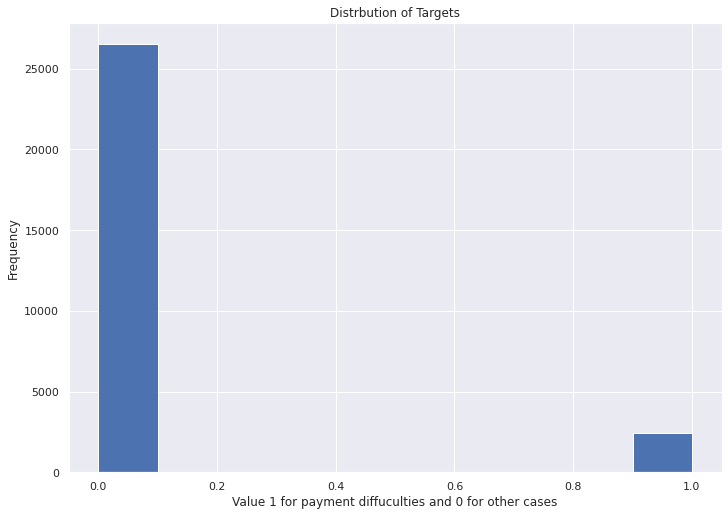

In [75]:
### YOUR CODE HERE ###
#Look into the function and corresponding parameters, sns.relplot;
import seaborn as sns
sns.set()

sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.title("Distrbution of Targets")
plt.xlabel("Value 1 for payment diffuculties and 0 for other cases")
all_data_combined['TARGET'].astype(int).plot.hist();

.... and one arbitrary pair of the features that you have created in the previous parts. Use appropriate figure size, title/caption, legend, and axis titles.

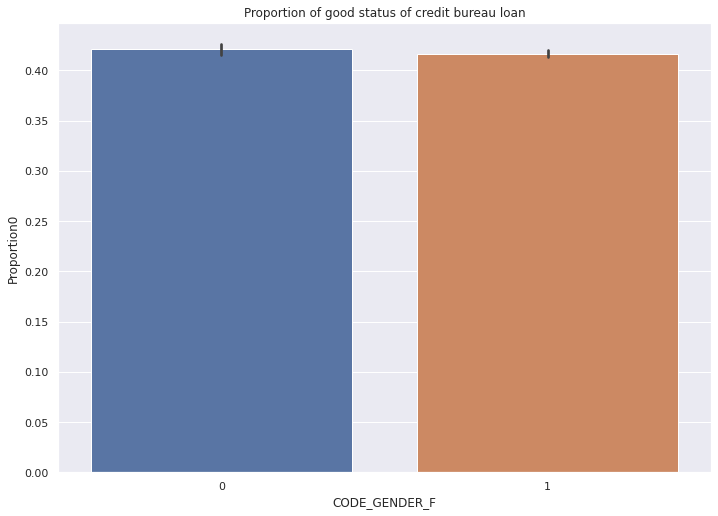

In [74]:
#sns.relplot(x="NAME_FAMILY_STATUS_Single / not married", y="PAID_ON_TIME_max", hue="'NAME_FAMILY_STATUS_Single / not married'", data=all_data_combined);


sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.title('Proportion of good status of credit bureau loan')
sns.barplot(x="CODE_GENDER_F", y="Proportion0", data=all_data_combined);


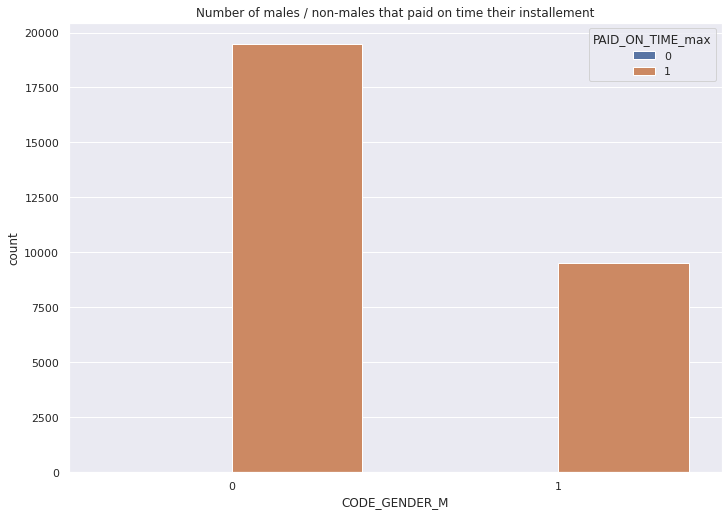

In [76]:
sns.countplot(x='CODE_GENDER_M', hue='PAID_ON_TIME_max', data=all_data_combined)
plt.title('Number of males / non-males that paid on time their installement')
plt.show()

more females paid on time 

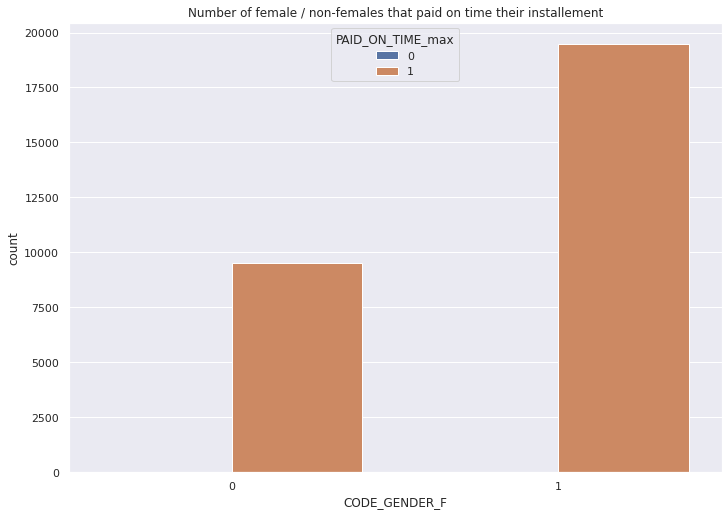

In [77]:
sns.countplot(x='CODE_GENDER_F', hue='PAID_ON_TIME_max', data=all_data_combined)
plt.title('Number of female / non-females that paid on time their installement')
plt.show()

Split the data into testing and training

In [78]:
X=all_data_combined.drop(['TARGET'],axis=1)
y=all_data_combined['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)

In [79]:
mylist=[

'ENTRANCES_MEDI',
'NONLIVINGAREA_MODE',
'AMT_CREDIT_MAX_OVERDUE',
'AMT_REQ_CREDIT_BUREAU_WEEK',
'AMT_DRAWINGS_CURRENT',
'AMT_TOTAL_RECEIVABLE',
'LIVINGAPARTMENTS_MEDI',
'COMMONAREA_MODE',
'DAYS_EMPLOYED',
'FLAG_EMP_PHONE',
'DEF_30_CNT_SOCIAL_CIRCLE',
'OBS_30_CNT_SOCIAL_CIRCLE',
'EXT_SOURCE_2',
'REGION_RATING_CLIENT',
'AMT_GOODS_PRICE',
'AMT_CREDIT',
'REG_REGION_NOT_WORK_REGION',
'REG_CITY_NOT_WORK_CITY',
'FLOORSMAX_AVG',
'ELEVATORS_AVG',
'CNT_INSTALMENT_FUTURE',
'PAID_ON_TIME_max',
'EXT_SOURCE_3',
'ProportionCredit card_x',
'FLOORSMIN_AVG',
'FLOORSMIN_MEDI',
'EXT_SOURCE_1',
'OCCUPATION_TYPE_Accountants',
       'OCCUPATION_TYPE_Cleaning staff', 'OCCUPATION_TYPE_Cooking staff',
       'OCCUPATION_TYPE_Core staff', 'OCCUPATION_TYPE_Drivers',
       'OCCUPATION_TYPE_HR staff',
       'OCCUPATION_TYPE_High skill tech staff',
       'OCCUPATION_TYPE_IT staff', 'OCCUPATION_TYPE_Laborers',
       'OCCUPATION_TYPE_Low-skill Laborers', 'OCCUPATION_TYPE_Managers',
       'OCCUPATION_TYPE_Medicine staff',
       'OCCUPATION_TYPE_Private service staff',
       'OCCUPATION_TYPE_Realty agents', 'OCCUPATION_TYPE_Sales staff',
       'OCCUPATION_TYPE_Secretaries', 'OCCUPATION_TYPE_Security staff',
       'OCCUPATION_TYPE_Waiters/barmen staff',
        
'CODE_GENDER_F', 'CODE_GENDER_M', 'CODE_GENDER_XNA',

'DAYS_REGISTRATION',

'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Married',
       'NAME_FAMILY_STATUS_Separated',
       'NAME_FAMILY_STATUS_Single / not married',
       'NAME_FAMILY_STATUS_Unknown', 'NAME_FAMILY_STATUS_Widow',
       'NAME_HOUSING_TYPE_Co-op apartment',
       'NAME_HOUSING_TYPE_House / apartment',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_Office apartment',
       'NAME_HOUSING_TYPE_Rented apartment',
       'NAME_HOUSING_TYPE_With parents',

'OWN_CAR_AGE',
'AMT_INCOME_TOTAL',
'FLAG_WORK_PHONE',
'FLAG_OWN_REALTY',
'NAME_CONTRACT_TYPE',
'CNT_FAM_MEMBERS',
'NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family',
       'NAME_TYPE_SUITE_Group of people', 'NAME_TYPE_SUITE_Other_A',
       'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse, partner',
       'NAME_TYPE_SUITE_Unaccompanied',
        
'WEEKDAY_APPR_PROCESS_START_FRIDAY',
       'WEEKDAY_APPR_PROCESS_START_MONDAY',
       'WEEKDAY_APPR_PROCESS_START_SATURDAY',
       'WEEKDAY_APPR_PROCESS_START_SUNDAY',
       'WEEKDAY_APPR_PROCESS_START_THURSDAY',
       'WEEKDAY_APPR_PROCESS_START_TUESDAY',
       'WEEKDAY_APPR_PROCESS_START_WEDNESDAY',
'DAYS_LAST_PHONE_CHANGE']
X_train_selected=X_train[mylist]
X_test_selected=X_test[mylist]

82 features were only selected (with one hot encoded features for sure) 

In [81]:
X_train_selected.shape

(20286, 82)

In [82]:
X_test_selected.shape

(8695, 82)

## **Part 2: Model Construction using Logistic Regression [10 Marks]**

* 2.1 Constructing the model [5 Marks]

Fit a logistic regression model using the selected explanatory variables and the training data.

In [83]:
# Fit logit model gonna use sklearn
from sklearn.linear_model import LogisticRegression

model1 = LogisticRegression(random_state=0).fit(X_train_selected, y_train)

In [84]:
model1.predict(X_test_selected)

array([0, 0, 0, ..., 0, 0, 0])

In [86]:
model1.predict_proba(X_test_selected)

array([[0.84637472, 0.15362528],
       [0.93583808, 0.06416192],
       [0.95407219, 0.04592781],
       ...,
       [0.9605154 , 0.0394846 ],
       [0.9187668 , 0.0812332 ],
       [0.94851821, 0.05148179]])

In [88]:
model1.score(X_test_selected, y_test)

0.9190339275445658

In [89]:
print("The model's coefficient are: ",end='\n')
model1.coef_

The model's coefficient are: 


array([[-4.88543777e-08, -3.56924130e-09,  3.90369753e-08,
        -1.23242119e-08, -1.62460073e-07,  1.44381715e-06,
        -2.92361325e-08, -8.47369278e-09, -2.55964443e-06,
        -2.22143247e-07, -1.18809202e-08, -4.02457007e-07,
        -2.55174464e-07, -6.63058303e-07, -2.06916016e-06,
         1.11707909e-06,  1.55302106e-08,  1.73676619e-08,
        -6.86117373e-08, -1.44866058e-08, -1.58260185e-06,
        -3.38046214e-07, -3.09098857e-07, -3.05695657e-08,
        -6.89115586e-08, -6.90884656e-08, -2.16389721e-07,
        -3.00291263e-08, -3.78026242e-09, -1.26467852e-08,
        -6.58941057e-08,  2.10793775e-08, -1.29827641e-09,
        -1.46892329e-08,  8.63407309e-10, -1.78970282e-07,
         5.93993185e-09, -4.99667777e-09, -1.79831880e-08,
        -6.98009785e-09, -4.17994752e-10, -2.63693240e-08,
        -2.87877035e-09,  4.48569421e-09, -3.53173978e-09,
        -4.13208471e-07,  7.51110182e-08,  0.00000000e+00,
         1.21046124e-04, -1.76931721e-08, -2.53738420e-0

* 2.2 Interpreting the model [5 Marks]

Interpret the estimated coefficients of the logistic regression model. 
Explain their impact on the response variable in plain English.

In [98]:
len(model1.coef_[0])

82

82 features ==> to 82 coefficients 

In [99]:
model1.coef_

array([[-4.88543777e-08, -3.56924130e-09,  3.90369753e-08,
        -1.23242119e-08, -1.62460073e-07,  1.44381715e-06,
        -2.92361325e-08, -8.47369278e-09, -2.55964443e-06,
        -2.22143247e-07, -1.18809202e-08, -4.02457007e-07,
        -2.55174464e-07, -6.63058303e-07, -2.06916016e-06,
         1.11707909e-06,  1.55302106e-08,  1.73676619e-08,
        -6.86117373e-08, -1.44866058e-08, -1.58260185e-06,
        -3.38046214e-07, -3.09098857e-07, -3.05695657e-08,
        -6.89115586e-08, -6.90884656e-08, -2.16389721e-07,
        -3.00291263e-08, -3.78026242e-09, -1.26467852e-08,
        -6.58941057e-08,  2.10793775e-08, -1.29827641e-09,
        -1.46892329e-08,  8.63407309e-10, -1.78970282e-07,
         5.93993185e-09, -4.99667777e-09, -1.79831880e-08,
        -6.98009785e-09, -4.17994752e-10, -2.63693240e-08,
        -2.87877035e-09,  4.48569421e-09, -3.53173978e-09,
        -4.13208471e-07,  7.51110182e-08,  0.00000000e+00,
         1.21046124e-04, -1.76931721e-08, -2.53738420e-0

In [100]:
X_train_selected

,ENTRANCES_MEDI,NONLIVINGAREA_MODE,AMT_CREDIT_MAX_OVERDUE,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_DRAWINGS_CURRENT,AMT_TOTAL_RECEIVABLE,LIVINGAPARTMENTS_MEDI,COMMONAREA_MODE,DAYS_EMPLOYED,FLAG_EMP_PHONE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,REGION_RATING_CLIENT,AMT_GOODS_PRICE,AMT_CREDIT,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_WORK_CITY,FLOORSMAX_AVG,ELEVATORS_AVG,CNT_INSTALMENT_FUTURE,PAID_ON_TIME_max,EXT_SOURCE_3,ProportionCredit card_x,FLOORSMIN_AVG,FLOORSMIN_MEDI,EXT_SOURCE_1,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,...,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,DAYS_REGISTRATION,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OWN_CAR_AGE,AMT_INCOME_TOTAL,FLAG_WORK_PHONE,FLAG_OWN_REALTY,NAME_CONTRACT_TYPE,CNT_FAM_MEMBERS,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,DAYS_LAST_PHONE_CHANGE
19769,0.2069,0.0502,1747.730769,0.0,31509.095806,15576.112742,0.1847,0.0569,0.646575,1,0.0,3.0,0.680630,2,247500.0,296505.0,0,0,0.3333,0.24,5.629630,1,0.374021,0.197802,0.2083,0.2083,0.238143,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,-4314.0,0,1,0,0,0,0,0,1,0,0,0,0,7.0,157500.0,0,1,0,3.0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,-498.0
3325,0.1379,0.0011,0.000000,0.0,0.000000,0.000000,0.0761,0.0190,4.515068,0,1.0,3.0,0.049568,2,450000.0,601470.0,0,0,0.1667,0.00,4.625000,1,0.670652,0.000000,0.2083,0.2083,0.505998,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,-8343.0,0,1,0,0,0,0,0,1,0,0,0,0,3.0,252000.0,0,1,0,2.0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,-124.0
14214,0.1379,0.0000,0.000000,1.0,11132.267442,187418.724070,0.0513,0.0282,2.252055,1,0.0,2.0,0.353390,2,522000.0,563341.5,0,0,0.1667,0.00,10.714286,1,0.524496,0.040000,0.2083,0.2083,0.568962,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,-9674.0,0,1,0,0,0,0,0,1,0,0,0,0,9.0,115650.0,0,1,0,2.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,-688.0
3983,0.1034,0.0759,321.895564,0.0,0.000000,-22.136250,0.1129,0.2641,3.164384,1,1.0,5.0,0.386493,2,742500.0,742500.0,0,0,0.4583,0.16,11.940000,1,0.497469,0.382625,0.3750,0.3750,0.667771,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,-1036.0,0,1,0,0,0,0,0,1,0,0,0,0,1.0,360000.0,0,1,0,3.0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,-2455.0
20029,0.4138,0.0011,0.000000,0.0,0.000000,0.000000,0.0761,0.0190,1.227397,1,0.0,0.0,0.654038,1,720000.0,876816.0,0,0,0.1667,0.00,8.250000,1,0.629674,0.333333,0.2083,0.2083,0.605105,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,-6908.0,0,0,1,0,0,0,0,1,0,0,0,0,9.0,166500.0,0,1,0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,-418.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20414,0.1379,0.0011,0.000000,0.0,0.000000,0.000000,0.0761,0.0190,7.030137,1,0.0,2.0,0.583

## After all this explanation (explanation below this) we can conclude that the coeffcients are 82 (one for each feature) and an increase by coef much of each leads to a decrease in the probability of having difficulty of paying a loan back since negative coefficients in a logistic regression model translate into odds ratios that are less than one. So our model is more likely to predict 0 (client has no difficulties in repaying loan) than 1 (client has difficulty) since any unit increase in any feat will decrease the proba of getting one. For ex for the first feature, an increase of one unit will decrease (-4.88543777e-08) the probability of obtaining 1 as a prediction and so on.. Hope that it is clear.

**Explanation**:

Logistic regression reminder for the case of continuous variable: 
A quick reminder about LR model. the output goes from 0 to 1 (probabilities) where 1 represents that the client have repayment problems and 0 the other cases (where the client will do well) . And depending of the higher probabibility taken between the two classes predicted takes 1 (have difficulties paying the loan) and the other 0 (has no problem of repaying the loan). 
As logistic regression is a Genelized Linear model (GLM). The log (p/1-p) we get a linear model from the logistic regression probilities predicted (we get a staight line that is the best fitting line with a y intersept and coe). After mapping this the probas from 0 to 0.5 maps to 0 to - inf and the probabilitie from 0.5 to 1 maps to 0 to +infinity . The coefficient obtained on this line are the one we get from Logistic regression . In plain english each coefficient means that for every one unit of feature1 gained (for example ENTRANCES_MEDI), the log(odds of having problem to pay loan) decrease by / or increases by x much. Since all of them are negative so an increase in each feature tend s

now for the case of
Logistic regression reminder for the case of dicrete variable:
In the context of testing a discrete variable, we fit two lines to the data based on the corresponding feature-prediction curve. The first line will represent the mean of the prediction with the selected feature (for example female ) and the second line the mean of the prediction with the contrary of  selected feature (not being a female). Then these two linesc coeme together to form the equation .. 
output(not able to pay loan) = mean(feat1)*B1 + (meanfeat1bar - meanfeat1)*B2 where B1 and B2 are coefficients 
We then pair this eq with a design matrix to predict the output given the following feature.  the same thing is done as before we transform the log (odds of a feature) this time. I wil not dig in the more details.
<br>


keep a copy of the files so that we dont have to re-run

In [101]:
all_data_combined.to_csv('all_data_combined_2.csv')
X_train.to_csv('X_train.csv')
X_train_selected.to_csv('X_train_selected.csv')
X_test.to_csv('X_test.csv')
X_test_selected.to_csv('X_test_selected.csv')

## **Part 3: Model Evaluation [25 Marks]**

* 3.1 Confusion matrix [5 Marks] 

Calculate the confusion matrix using the testing set. 

In [103]:
### YOUR CODE HERE ###
#Look into the function and corresponding parameters; confusion_matrix
confusion = metrics.confusion_matrix(y_test, model1.predict(X_test_selected))
print(confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print('\n')
print("The true positive value is: ",TP)
print("The true negative value is: ",TN)

print("The false positive value is: ",FP)
print("The false negative value is: ",FN)

[[7991    0]
 [ 704    0]]


The true positive value is:  0
The true negative value is:  7991
The false positive value is:  0
The false negative value is:  704


* 3.2 Explaining the confusion matrix [5 Marks]

Explain a weakness or a strength of the model based on the confusion matrix. 

The weakness is clear from having a True positive rate and FP of 0! As we saw from our model before the data is unbalanced towards clients that can repay the loan back (classified as 0). We expect a very low precision then when uing logistic regresion . The model1.score(X_test_selected, y_test) gave a accuracy higher than 90 % but that is because our model is predicting 0s and most of the values in y-test are 0s and so leaidng to high accuracy. I am pretty sure that the precision, recall and f1_score are bad for this model like 0 since computing their formulas having TP=0 and FP-0 will lead to 0 values for the three performance metrics . The predictions are all 0s the model is not predicting 1s. This is proved in the code below. The model is not distinguishing between the positive and negative classes (the auc will be then bad).

This model is strengh is a way it ha a high accuracy on the testing data. It is on the client to choose what is the best depending on the application.

In [122]:
y_pred=model1.predict(X_test_selected)

In [123]:
count=0
for elem in y_pred:
  if elem==1:
    count=count+1

In [124]:
count

0

* 3.3 Graphic illustration of the performance [5 Marks]

Plot the ROC curve (receiver operating characteristic curve) showing the performance of the model.
Calculate AUC (Area under the curve) respectively

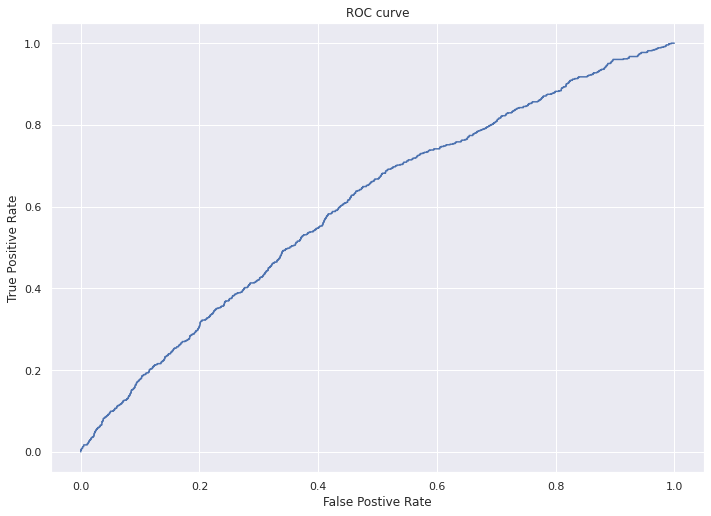

In [104]:
#https://www.statology.org/plot-roc-curve-python/
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

fpr,tpr,thresholds=roc_curve(y_test,model1.predict_proba(X_test_selected)[:,1])
plt.figure()
plt.plot(fpr,tpr)
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")

plt.show()

In [108]:
print("The AUC score: ",roc_auc_score(y_test, model1.predict_proba(X_test_selected)[:, 1]))

The AUC score:  0.6034436112785976


if we use the model.predict alone we will get an AUC score of 0.5

* 3.4 Compute the performance measures [5 Marks]

Compute the following measures to assess the performance of the logistic regression model: 
    precision, recall, F_1-score, accuracy, and total misclassification rate; 
    using the testing set.

In [112]:
### YOUR CODE HERE ###
#Given the confusion matrix result, note that this can be computed manually using formula as well 
# i will just use the packages from sklearn faster 
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
print("The precision score is: ",precision_score(y_test, model1.predict(X_test_selected)))
print("The f1 score is: ",f1_score(y_test, model1.predict(X_test_selected)) )
print("The accuracy score is: ",accuracy_score(y_test, model1.predict(X_test_selected)) )
print("The total missclasfication score is: ",1 - accuracy_score(y_test, model1.predict(X_test_selected)) )
print("The recall score is: ",recall_score(y_test, model1.predict(X_test_selected)) )

The precision score is:  0.0
The f1 score is:  0.0
The accuracy score is:  0.9190339275445658
The total missclasfication score is:  0.08096607245543419
The recall score is:  0.0


* 3.5 Suitable performance measures for reporting [5 Marks]

If you were to only choose two of the five performance measures for reporting, which ones do you choose? 
Justify your choice.

Using  ONLY the testing accuracy will be a very ad idea and will trick the client. Like having y_test of majoritarely 0s and having predictions all of 0s. 
I would surely choose 2 giving different insights of the prediction to not trick the client and he can choose if he wants the model depending on the application .
I would choose the testing accuracy (or missclassification rate since they are giving the samee message) and the second performance metric would be the f1_score since it combines precision and recall in a single formula and from it (here =0.0) the client can conclude that the recall is 0 and the precision is 0.

## **Part 4: Alternative classification model [20 marks]**
Select an alternative classification model that has at least one tunable hyper-parameter.

**HINT !**

You might want to try random forest or boosted tree etc.

* 4.1 Train the alternative classification model [5 marks]

Train your alternative model on the same training set.

https://obrunet.github.io/data%20science/Home_credit_default_risk/
I've searched on google and I will use Light Gradient Boosted Machine (LGBM) which is a boosted tree as mentonned in the hint

In [194]:
### YOUR CODE HERE ###
# LIght gbm
import lightgbm as lgb
import xgboost as xgb

model2 = lgb.LGBMClassifier(random_state = 0,nb_jobs=-1,max_depth=9,class_weight = 'balanced')
model2.fit(X_train_selected, y_train, eval_metric = 'auc')
roc_auc_score(y_train, model2.predict(X_train_selected))

0.8815878613893144

In [195]:
roc_auc_score(y_test, model2.predict(X_test_selected))

0.6562607542860718

In [196]:
print("The precision score is: ",precision_score(y_test, model2.predict(X_test_selected)))
print("The f1 score is: ",f1_score(y_test, model2.predict(X_test_selected)) )
print("The accuracy score is: ",accuracy_score(y_test, model2.predict(X_test_selected)) )
print("The total missclasfication score is: ",1 - accuracy_score(y_test, model2.predict(X_test_selected)) )
print("The recall score is: ",recall_score(y_test, model2.predict(X_test_selected)) )

The precision score is:  0.18277945619335348
The f1 score is:  0.2698884758364312
The accuracy score is:  0.7741230592294422
The total missclasfication score is:  0.22587694077055775
The recall score is:  0.515625


This look promising we can achieve more by tuning!

* 4.2 Tune the alternative classification model [5 Marks]

Use a k-fold cross validation to tune the hyper-parameters of the alternative model based on accuracy. 

In [165]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier

In [166]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

https://www.kaggle.com/ashishpatel26/kfold-lightgbm

In [193]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
#Question 1
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
def klgmb(X_train,y_train):
 
  temp=[]
  temp2=[]
  for k in range(1,13):
    lgbm = lgb.LGBMClassifier(random_state = 0,nb_jobs=-1,max_depth=k,class_weight = 'balanced')
    scores = cross_validate(lgbm, X_train, y_train, cv=5,scoring=('roc_auc'),return_train_score=True)
    print(scores)
    train_auc=scores['train_score']
    val_auc= scores['test_score']
    temp.append(max(val_auc))
    temp2.append(max(train_auc))
  
  maxsofar=temp[0]
  for i in range(0,len(temp)):
    #find the maximum k 
    if(temp[i]>maxsofar):
      maxsofar=temp[i]
  bestk=temp.index(maxsofar)+1
  return temp,temp2,maxsofar,bestk

validation_accuracies,training_accuracies,maxsofar_original,bestk=klgmb(X_train_selected,y_train)
print("Validation AUC: ",validation_accuracies)
print("Training AUC: ",training_accuracies)
print("The highest cross validation AUC is:",maxsofar_original)
print("The first best max_depth corresponding to the highest cross validation accuracy is:",bestk)

{'fit_time': array([0.28752184, 0.23541403, 0.83593488, 0.26042891, 1.16184449]), 'score_time': array([0.05256271, 0.01147389, 0.01220965, 0.01166892, 0.01097012]), 'test_score': array([0.71790914, 0.73102316, 0.7501607 , 0.74454545, 0.71234614]), 'train_score': array([0.75175869, 0.74855996, 0.74698294, 0.74642412, 0.75274968])}
{'fit_time': array([0.28824949, 0.24709535, 0.13545346, 0.13614559, 0.14502764]), 'score_time': array([0.04228687, 0.01195693, 0.01231098, 0.01198339, 0.01275134]), 'test_score': array([0.72621175, 0.734157  , 0.75023546, 0.74622837, 0.7222259 ]), 'train_score': array([0.78506568, 0.78374598, 0.78001613, 0.78036481, 0.78504862])}
{'fit_time': array([0.16701365, 0.17067695, 0.16253591, 0.16331005, 0.17635536]), 'score_time': array([0.01271367, 0.01262569, 0.01225638, 0.01262379, 0.01781249]), 'test_score': array([0.72420776, 0.73035724, 0.74194921, 0.738625  , 0.7264041 ]), 'train_score': array([0.82114263, 0.8249741 , 0.81853654, 0.82169861, 0.82109993])}
{'fi

Better auc score is achieved on testing set than logistoic regression 
0.6797991312669934

In [201]:
model3 = lgb.LGBMClassifier(random_state = 0,nb_jobs=-1,max_depth=2,class_weight = 'balanced')
model3.fit(X_train_selected, y_train, eval_metric = 'auc')
print(roc_auc_score(y_train, model3.predict(X_train_selected)))
print(roc_auc_score(y_test, model3.predict(X_test_selected)))

0.6973995822187697
0.6797991312669934


We found that using max_depth=2 we obtain the highest Cross validation AUC. I chose AUC as a performanc metric since we want to acheive better recall and precisionAs training for more than 1 parameters require nested loops and thus more time 

* 4.3 Confusion matrix [5 Marks]

Calculate the confusion matrix using the testing set.

In [204]:
### YOUR CODE HERE ###
#Look into the function and corresponding parameters; confusion_matrix
confusion = metrics.confusion_matrix(y_test, model3.predict(X_test_selected))
print(confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print('\n')
print("The true positive value is: ",TP)
print("The true negative value is: ",TN)

print("The false positive value is: ",FP)
print("The false negative value is: ",FN)

[[5541 2450]
 [ 235  469]]


The true positive value is:  469
The true negative value is:  5541
The false positive value is:  2450
The false negative value is:  235


* 4.4 Graphic illustration of the performance [5 Marks]

Plot the ROC curve (receiver operating characteristic curve) showing the performance of the model.
Calculate AUC (Area under the curve) respectively

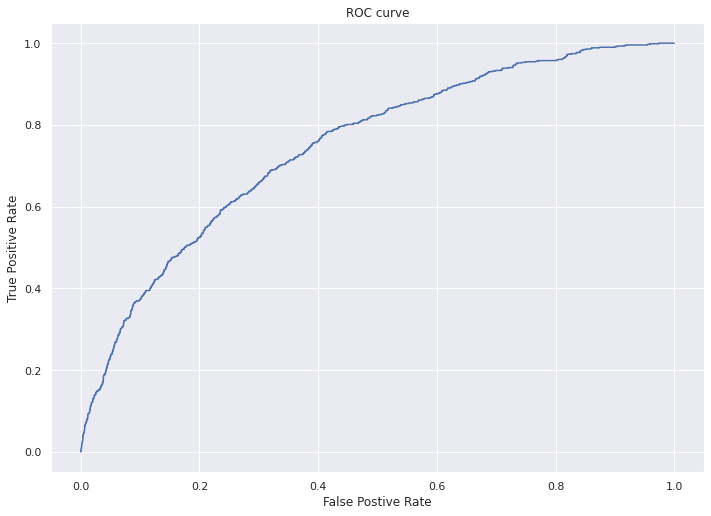

In [205]:
#https://www.statology.org/plot-roc-curve-python/
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

fpr,tpr,thresholds=roc_curve(y_test,model3.predict_proba(X_test_selected)[:,1])
plt.figure()
plt.plot(fpr,tpr)
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")

plt.show()

In [206]:
print("The AUC score: ",roc_auc_score(y_test, model3.predict_proba(X_test_selected)[:, 1]))

The AUC score:  0.7471723337902867


In [207]:
print("The precision score is: ",precision_score(y_test, model3.predict(X_test_selected)))
print("The f1 score is: ",f1_score(y_test, model3.predict(X_test_selected)) )
print("The accuracy score is: ",accuracy_score(y_test, model3.predict(X_test_selected)) )
print("The total missclasfication score is: ",1 - accuracy_score(y_test, model3.predict(X_test_selected)) )
print("The recall score is: ",recall_score(y_test, model3.predict(X_test_selected)) )

The precision score is:  0.1606714628297362
The f1 score is:  0.2589014628760695
The accuracy score is:  0.6912018401380103
The total missclasfication score is:  0.30879815986198966
The recall score is:  0.6661931818181818


Higher recall but lower accuracy 

## **Part 5: Compare the two models [15 Marks]**

Use the test data to compare the logistic regression model and the tuned alternative model.

* 5.1 Compare predictive performance [5 Marks]

Choose a suitable plot and illustrate all the five performance measures (precision, recall, F_1-score, accuracy, and total misclassification rate) for the two models. 
Use appropriate figure size, title/caption, legend, and axis titles.

# I mean by model2 the model in the second part (but its name on variable python is model3)

In [273]:
### YOUR CODE HERE ###
#bar plot


precision=precision_score(y_test, model1.predict(X_test_selected))
recall=recall_score(y_test, model1.predict(X_test_selected))
F_1score=f1_score(y_test, model1.predict(X_test_selected))
accuracy=accuracy_score(y_test, model1.predict(X_test_selected))
totalmisclassificationrate=1 - accuracy_score(y_test, model1.predict(X_test_selected))
model1perf=[precision,recall,F_1score,accuracy1,totalmisclassificationrate]

precision1=precision_score(y_test, model3.predict(X_test_selected))
recall1=recall_score(y_test, model3.predict(X_test_selected))
F_1score1=f1_score(y_test, model3.predict(X_test_selected))
accuracy1=accuracy_score(y_test, model3.predict(X_test_selected))
totalmisclassificationrate1=1 - accuracy_score(y_test, model3.predict(X_test_selected))
model2perf=[precision1,recall1,F_1score1,accuracy1,totalmisclassificationrate1]

Text(0.5, 1.0, 'Compare predictive performance of Logistic Regression model (model 1) and LGBM (model 2)')

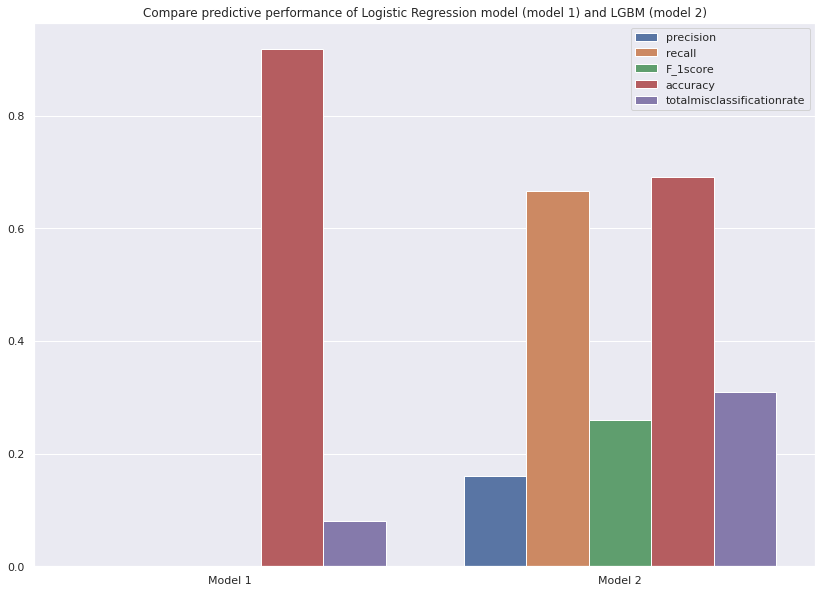

In [274]:
# Set the figure size
#https://stackoverflow.com/questions/53561766/seaborn-barplot-from-lists-instead-of-dataframes
plt.figure(figsize=(14, 10))

# plot a bar chart with given order of bars ["Fri","Thur","Sun","Sat"]
import seaborn as sn

raw_data = {
    # cat:                      B                 
    'x': ['Model 1',          'Model 1',         'Model 1',     'Model 1', 'Model 1',
          'Model 2',          'Model 2',         'Model 2',     'Model 2', 'Model 2'
            ],

    'y': [precision,  recall, F_1score, accuracy, totalmisclassificationrate,
         precision1,  recall1, F_1score1, accuracy1, totalmisclassificationrate1,
          ],
    'category': ['precision', 'recall', 'F_1score', 'accuracy','totalmisclassificationrate','precision', 'recall', 'F_1score', 'accuracy','totalmisclassificationrate']
           }

sn.barplot(x='x', y='y', hue='category', data=raw_data)
plt.title("Compare predictive performance of Logistic Regression model (model 1) and LGBM (model 2)")

* 5.2 Recommend model to client (scenario 1) [5 Marks]

Among the two models you have developed, what is you suggested model to Home Credit Group (client of the project), 
if they are more concerned about rejecting applications of individuals who may otherwise end up having difficulty in repayment? 
 Provide a numeric measure for each of the two models to justify your response.


Answer: <br>
In this case the Home Credit Group (our client) cares about knowing that the creditors (their clients) will not repay. Our first model is predicting that everyone will repay with a precision of 0 and a recall of 0 so this model will be very useless for their application since it will always predict that the client is able to pay back the loan and not reject any application. 
From the confusion matrix both true positive and false positive value are  0 for model 1 and that's so bad for this kind of application where we want to reject clients not able to repay.
On the other hand, for model2 the TP and FP values are respectively 469 and 2450.
A good numerical value is also f1 score that is 0 for model 1 and  0.26 . Remind  F1 scores can range from 0 to 1, with 1 representing a model that perfectly classifies each observation into the correct class and 0 representing a model that is unable to classify any observation into the correct class.  (https://www.statology.org/what-is-a-good-f1-score/) 
Also model 1 = 0.603 have a smaller AUC than model 2 = 0.7471723337902867 and a high area under the curve represents both high recall and high precision which we care about here more than classification testing accuracy or missclassifiation rate that only  tells you the fraction of the predictions that were wrong. 


* 5.3 Recommend model to client (scenario 2) [5 Marks]

Among the two models you have developed, what is you suggested model to Home Credit Group (client of the project), 
if they are more concerned about not rejecting applications of individuals who may be capable of repayment according to the data? 
 Provide a numeric measure for each of the two models to justify your response.

In this case the Home Credit Group (our client) cares about accepting the most creditors (their clients) . Our first model is predicting that everyone will repay with a precision of 0 and a recall of 0 so this model with some minor improvements can be useful for our client.
Model 2 has a testing acuracy score  of  0.6912018401380103 and 0.30879815986198966 so  a big fraction of the predictions that were wrong (but at the end of the day it is the bias variance trade off that we talked about) and model 1 has an  accuracy score is:  0.9190339275445658 and The total missclasfication score is:  0.08096607245543419 . Which is way better suited for the following application. We might need to improve our model a little bit because having a 0 precision and recall is also very low (like 0).